In [ ]:
# Customer Segmentation: Mall Customers Dataset
# Unsupervised Learning with K-Means, PCA, and t-SNE

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [8]:
# ==============================
# Dataset Loading
# ==============================
from google.colab import files
import pandas as pd

# Let user upload file
uploaded = files.upload()

# Get the filename automatically
data_path = list(uploaded.keys())[0]

# Load dataset
df = pd.read_csv(data_path)
print("Dataset Shape:", df.shape)
print(df.head())


Saving Mall_Customers.csv to Mall_Customers (1).csv
Dataset Shape: (200, 5)
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


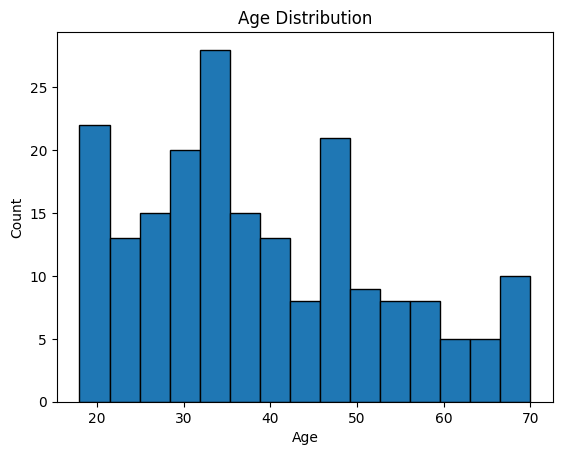

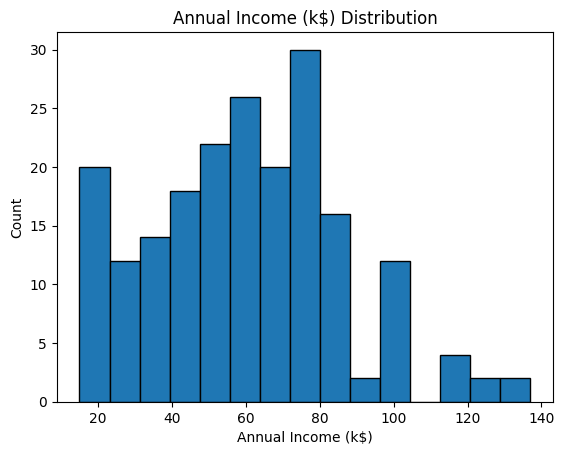

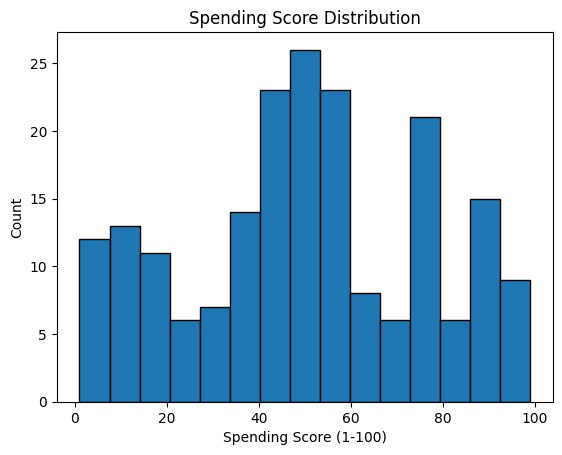

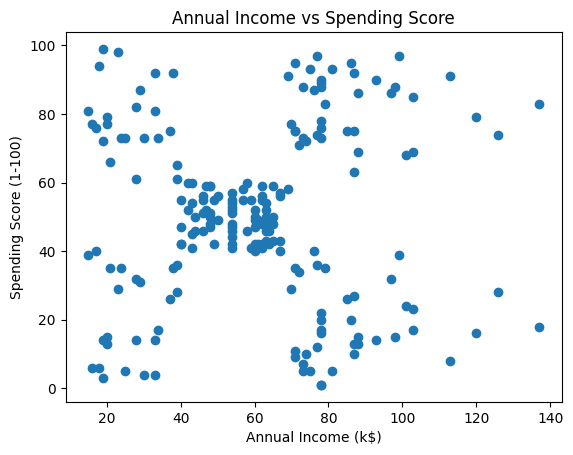

In [9]:
# ==============================
# Exploratory Data Analysis (EDA)
# ==============================
plt.figure(); plt.hist(df["Age"], bins=15, edgecolor="black")
plt.title("Age Distribution"); plt.xlabel("Age"); plt.ylabel("Count"); plt.show()

plt.figure(); plt.hist(df["Annual Income (k$)"], bins=15, edgecolor="black")
plt.title("Annual Income (k$) Distribution"); plt.xlabel("Annual Income (k$)"); plt.ylabel("Count"); plt.show()

plt.figure(); plt.hist(df["Spending Score (1-100)"], bins=15, edgecolor="black")
plt.title("Spending Score Distribution"); plt.xlabel("Spending Score (1-100)"); plt.ylabel("Count"); plt.show()

plt.figure(); plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"])
plt.title("Annual Income vs Spending Score")
plt.xlabel("Annual Income (k$)"); plt.ylabel("Spending Score (1-100)"); plt.show()

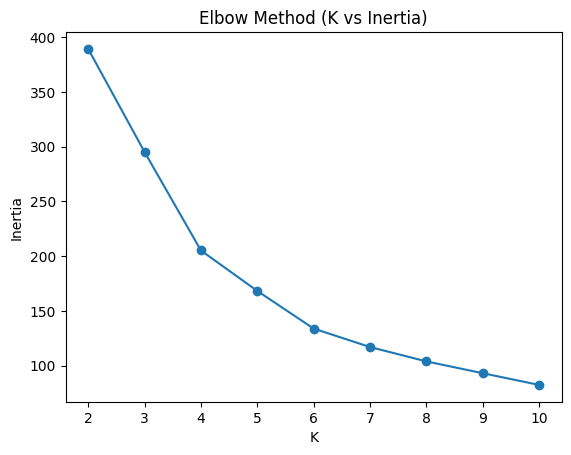

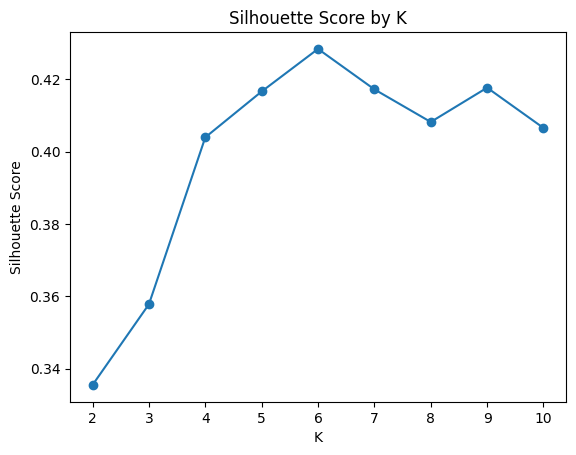

Best K (Silhouette): 6


In [10]:
# ==============================
# Model Building & Evaluation: K-Means
# ==============================
inertias, silhouettes = [], []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(); plt.plot(list(k_range), inertias, marker="o")
plt.title("Elbow Method (K vs Inertia)")
plt.xlabel("K"); plt.ylabel("Inertia"); plt.xticks(list(k_range)); plt.show()

plt.figure(); plt.plot(list(k_range), silhouettes, marker="o")
plt.title("Silhouette Score by K")
plt.xlabel("K"); plt.ylabel("Silhouette Score"); plt.xticks(list(k_range)); plt.show()

best_k = int(np.argmax(silhouettes) + k_range.start)
print("Best K (Silhouette):", best_k)

In [11]:
# ==============================
# Final KMeans Clustering
# ==============================
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

df_res = df.copy()
df_res["Cluster"] = labels

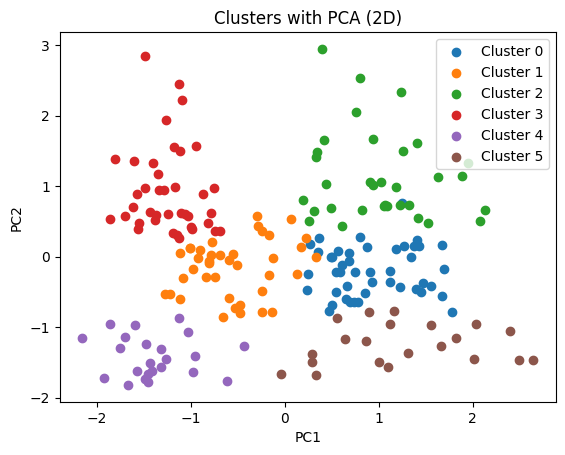

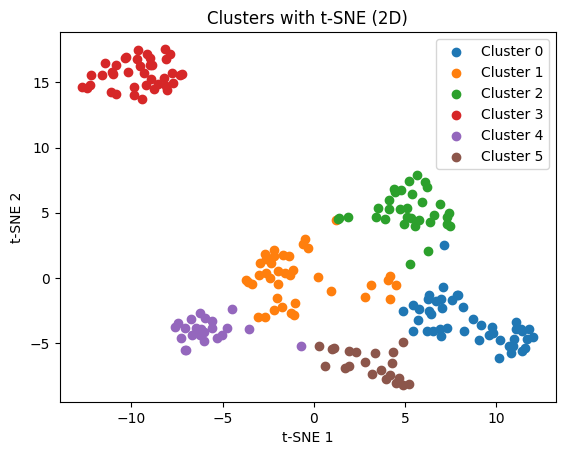

In [12]:
# ==============================
# Cluster Visualization
# ==============================
# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
for c in range(best_k):
    plt.scatter(X_pca[labels == c, 0], X_pca[labels == c, 1], label=f"Cluster {c}")
plt.title("Clusters with PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto", perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure()
for c in range(best_k):
    plt.scatter(X_tsne[labels == c, 0], X_tsne[labels == c, 1], label=f"Cluster {c}")
plt.title("Clusters with t-SNE (2D)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.legend(); plt.show()

In [13]:
# ==============================
# Cluster Profiling
# ==============================
profile = df_res.groupby("Cluster")[features].agg(
    ["mean", "median", "min", "max", "count"]
).round(2)
print("\nCluster Profiles:\n", profile)


Cluster Profiles:
            Age                      Annual Income (k$)                        \
          mean median min max count               mean median min  max count   
Cluster                                                                        
0        56.33   54.0  43  70    45              54.27   54.0  38   79    45   
1        26.79   26.0  18  40    39              57.10   60.0  39   76    39   
2        41.94   43.0  19  59    33              88.94   86.0  71  137    33   
3        32.69   32.0  27  40    39              86.54   79.0  69  137    39   
4        25.00   23.0  18  35    23              25.26   24.0  15   39    23   
5        45.52   46.0  20  67    21              26.29   25.0  16   39    21   

        Spending Score (1-100)                       
                          mean median min max count  
Cluster                                              
0                        49.07   49.0  35  60    45  
1                        48.13   50.0  10  

In [14]:
# ==============================
# Marketing Strategies
# ==============================
def describe_segment(row):
    age_mean = row[("Age", "mean")]
    inc_mean = row[("Annual Income (k$)", "mean")]
    spend_mean = row[("Spending Score (1-100)", "mean")]
    traits = []
    if age_mean < 30: traits.append("younger")
    elif age_mean < 45: traits.append("middle-aged")
    else: traits.append("older")
    if inc_mean < 40: traits.append("lower-to-mid income")
    elif inc_mean < 80: traits.append("mid-to-high income")
    else: traits.append("high income")
    if spend_mean < 40: spend_tier = "low spenders"
    elif spend_mean < 70: spend_tier = "moderate spenders"
    else: spend_tier = "high spenders"
    return traits, spend_tier

def marketing_strategy(row):
    traits, spend_tier = describe_segment(row)
    tactics = []
    if spend_tier == "high spenders":
        tactics += ["VIP rewards and early access", "Exclusive events", "Personalized recommendations"]
    elif spend_tier == "moderate spenders":
        tactics += ["Targeted bundles", "Cross-selling", "Gamified loyalty points"]
    else:
        tactics += ["Entry-level discounts", "Awareness campaigns", "Free shipping thresholds"]
    if "younger" in traits:
        tactics += ["Mobile-first campaigns", "Influencer partnerships", "Student discounts"]
    elif "middle-aged" in traits:
        tactics += ["Family bundles", "Convenience messaging"]
    else:
        tactics += ["Quality & reliability focus", "In-store assistance"]
    if "high income" in traits:
        tactics += ["Premium product lines", "Invite-only memberships"]
    elif "lower-to-mid income" in traits:
        tactics += ["Value packs", "Installment plans"]
    return traits, spend_tier, tactics[:5]

strategies = []
for c, row in profile.iterrows():
    traits, spend_tier, tactics = marketing_strategy(row)
    strategies.append({
        "Cluster": c,
        "Segment Traits": ", ".join(traits) + f"; {spend_tier}",
        "Top 5 Tactics": tactics
    })

strategies_df = pd.DataFrame(strategies)
print("\nMarketing Strategies per Cluster:\n", strategies_df)


Marketing Strategies per Cluster:
    Cluster                                  Segment Traits  \
0        0    older, mid-to-high income; moderate spenders   
1        1  younger, mid-to-high income; moderate spenders   
2        2          middle-aged, high income; low spenders   
3        3         middle-aged, high income; high spenders   
4        4     younger, lower-to-mid income; high spenders   
5        5        older, lower-to-mid income; low spenders   

                                       Top 5 Tactics  
0  [Targeted bundles, Cross-selling, Gamified loy...  
1  [Targeted bundles, Cross-selling, Gamified loy...  
2  [Entry-level discounts, Awareness campaigns, F...  
3  [VIP rewards and early access, Exclusive event...  
4  [VIP rewards and early access, Exclusive event...  
5  [Entry-level discounts, Awareness campaigns, F...  


In [15]:
# ==============================
# Conclusion
# ==============================
print("\nConclusion:")
print(f"- Optimal clusters (K): {best_k}")
print("- Distinct customer segments identified.")
print("- Segment-specific strategies suggested for targeted marketing.")


Conclusion:
- Optimal clusters (K): 6
- Distinct customer segments identified.
- Segment-specific strategies suggested for targeted marketing.


In [16]:
import joblib, gzip
from google.colab import files

# Save compressed model
with gzip.open("kmeans_model.pkl.gz", "wb") as f:
    joblib.dump(kmeans, f)

# Download the file
files.download("kmeans_model.pkl.gz")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>